# Dimensionality Reduction
> ## Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution, as we will see. This problem is often referred to as *the curse of dimensionality.*

The two main approaches for dimensionality reduction are:
* Projection
  * PCA
  * KernelPCA
  * IncrementalPCA
* Manifold Learning
  * LLE (Locally Linear Embedding)


Here , we're using the last (Classification) dataset for ransomeware ,to apply the dimensionality reduction and its impact on training and test sets evaluation metrics

# Importing Necessary Libraries

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.naive_bayes as nb

from sklearn.svm import LinearSVC , SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier , ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier , BaggingClassifier, VotingClassifier , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler , OrdinalEncoder
from sklearn.decomposition import PCA , IncrementalPCA,KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score , f1_score
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Getting data

In [2]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/ransome.csv")
df.head()

,Time,Protcol,Flag,Family,Clusters,SeddAddress,ExpAddress,BTC,USD,Netflow_Bytes,IPaddress,Threats,Port,Prediction
0,50,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,500,5,A,Bonet,5061,SS
1,40,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,504,8,A,Bonet,5061,SS
2,30,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,508,7,A,Bonet,5061,SS
3,20,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,512,15,A,Bonet,5061,SS
4,57,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,516,9,A,Bonet,5061,SS


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149043 entries, 0 to 149042
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Time           149043 non-null  int64 
 1   Protcol        149043 non-null  object
 2   Flag           149043 non-null  object
 3   Family         149043 non-null  object
 4   Clusters       149043 non-null  int64 
 5   SeddAddress    149043 non-null  object
 6   ExpAddress     149043 non-null  object
 7   BTC            149043 non-null  int64 
 8   USD            149043 non-null  int64 
 9   Netflow_Bytes  149043 non-null  int64 
 10  IPaddress      149043 non-null  object
 11  Threats        149043 non-null  object
 12  Port           149043 non-null  int64 
 13  Prediction     149043 non-null  object
dtypes: int64(6), object(8)
memory usage: 15.9+ MB


In [4]:
df.describe()

,Time,Clusters,BTC,USD,Netflow_Bytes,Port
count,149043.000000,149043.000000,149043.000000,149043.000000,149043.000000,149043.000000
mean,21.466979,2.349295,30.554605,14863.441114,2021.278651,5063.949967
std,15.883598,2.828759,101.447102,26849.434659,2271.420987,2.696011
min,-10.000000,1.000000,1.000000,1.000000,1.000000,5061.000000
25%,8.000000,1.000000,8.000000,512.000000,353.000000,5062.000000
50%,19.000000,1.000000,13.000000,4321.000000,1031.000000,5062.000000
75%,32.000000,2.000000,22.000000,18454.000000,3188.000000,5066.000000
max,96.000000,12.000000,1980.000000,126379.000000,12360.000000,5068.000000


In [5]:
target = "Prediction"

features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep = True)

features

['Time',
 'Protcol',
 'Flag',
 'Family',
 'Clusters',
 'SeddAddress',
 'ExpAddress',
 'BTC',
 'USD',
 'Netflow_Bytes',
 'IPaddress',
 'Threats',
 'Port']

# Exploraing Data

In [6]:
df[features].nunique().sort_values()

,0
Protcol,3
IPaddress,4
Port,4
SeddAddress,6
ExpAddress,7
Flag,9
Clusters,9
Threats,9
Family,17
Time,87


In [7]:
# splitting the features into categorical and numerical features

cf = [] ; nf = [] ;

for i in features:
  if df[i].nunique() <= 15:
    cf.append(i)
  else:
    nf.append(i)
print("\n\033[1mCategorical Features ----> {}".format(cf))
print("\n\033[1mNumerical Features ----> {}".format(nf))


Categorical Features ----> ['Protcol', 'Flag', 'Clusters', 'SeddAddress', 'ExpAddress', 'IPaddress', 'Threats', 'Port']

Numerical Features ----> ['Time', 'Family', 'BTC', 'USD', 'Netflow_Bytes']


<Figure size 1000x800 with 0 Axes>

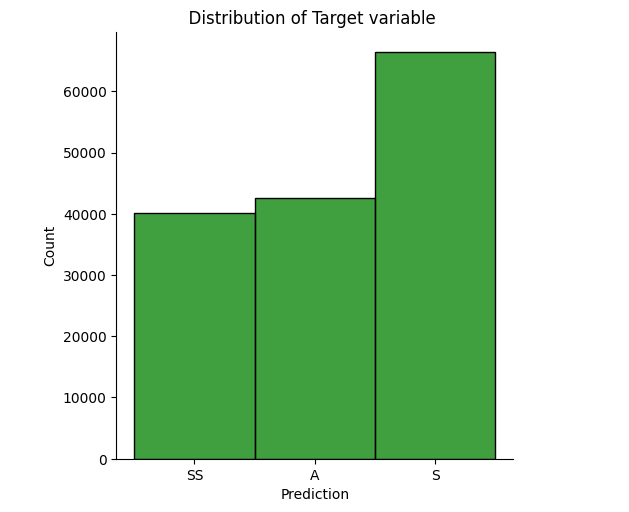

In [8]:
# checking the distribution of the  target variable

plt.figure(figsize = (10,8))

sns.displot(df[target],bins = 30 , color = "green")
plt.title("Distribution of Target variable".center(100))
plt.show()

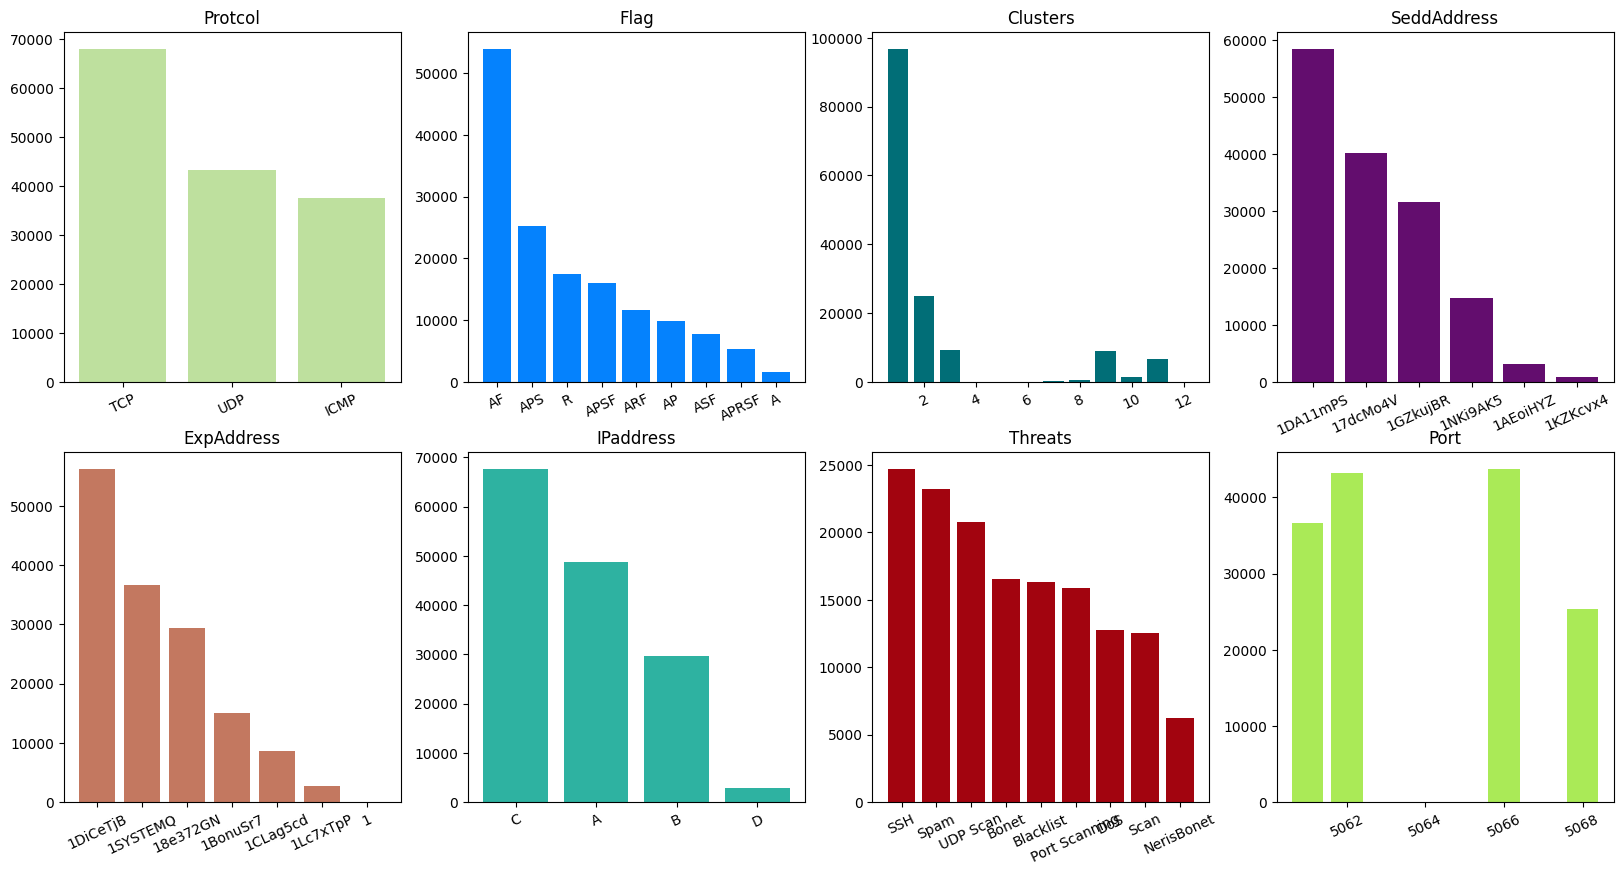

In [9]:
# plotting categorical features
fig = plt.figure(figsize=(20,10))
for i in range(len(cf)):
  plt.subplot(2,4,i+1)
  plt.bar(list(df[cf[i]].value_counts().keys()),df[cf[i]].value_counts(),color = np.random.randint([255,255,255])/255)
  plt.xticks(rotation=25)
  plt.title(cf[i])
plt.show()

<Figure size 20000x20000 with 0 Axes>

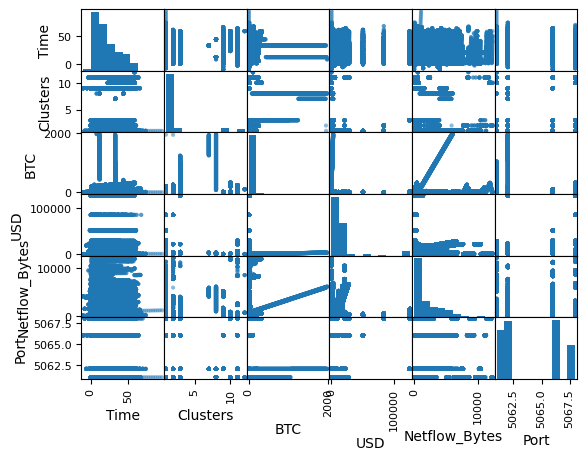

In [10]:
# checking the relationship between features

from pandas.plotting import scatter_matrix
plt.figure(figsize = (200,200))
scatter_matrix(df[features])
plt.show()

In [11]:
def plot_linear(x= None , y = None ):
  plt.figure(figsize=(15,10))
  plt.plot(df[x],df[y],ms = 5, marker ="o")
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

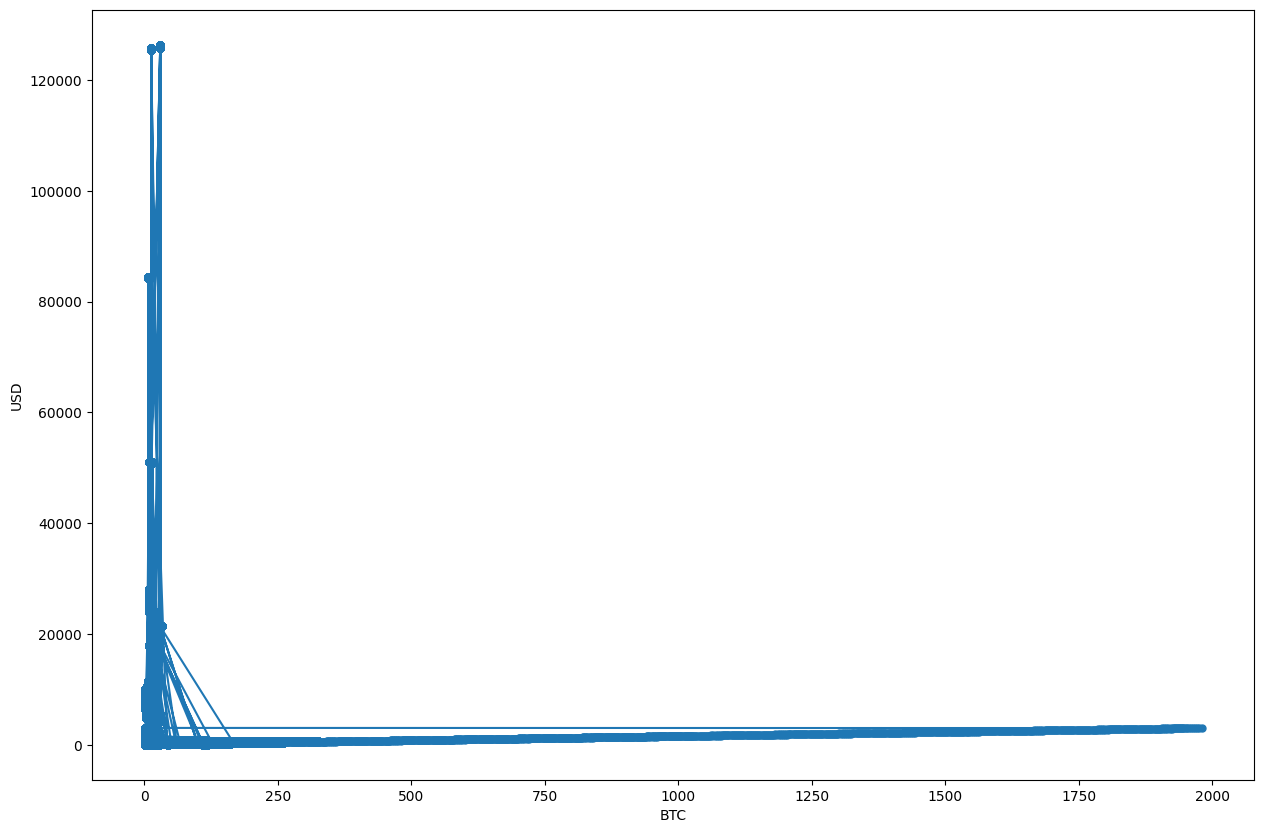

In [12]:
# relation among USD and BTC

plot_linear("BTC","USD")


In [13]:
# relation among usd and btc
def plot_scatter(x= "BTC",y="USD"):
  plt.scatter(df[x],df[y])
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

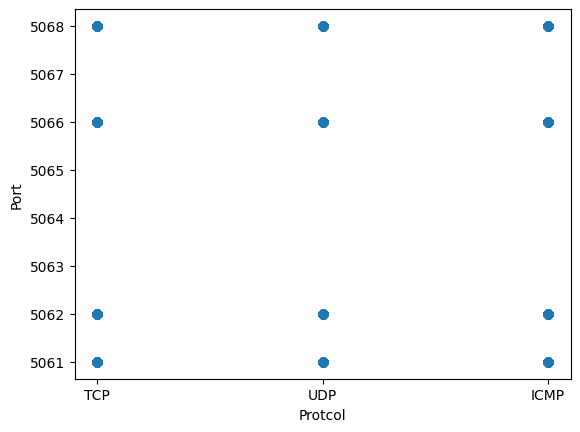

In [14]:
plot_scatter("Protcol","Port")

In [15]:
nf.remove("Family")

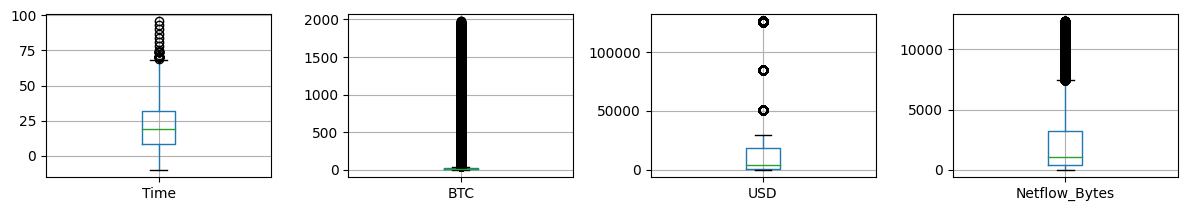

In [16]:
n=5
# nf.remove("Family")
plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

In [17]:
# Removing Duplicates

df2 = df.drop_duplicates()
print("\n\033[1m Before removing of duplicates data set consists {} samples".format(df.shape[0]))
print("\n\033[1m After removing of duplicates data set consists {} samples".format(df2.shape[0]))


 Before removing of duplicates data set consists 149043 samples

 After removing of duplicates data set consists 149043 samples


In [18]:
df3 = original_df.copy(deep = True)
for i in range(len(cf)):
  if df3[cf[i]].nunique() <= 8 :
    df3 = pd.concat([df3.drop(cf[i],axis = 1),pd.get_dummies(df3[cf[i]],prefix = str(i))],axis =1)
  else:
    df3 = pd.concat([df3.drop(cf[i],axis = 1),pd.get_dummies(df3[cf[i]],prefix =str(i),drop_first = True)],axis =1)

In [19]:
df3.head()

,Time,Family,BTC,USD,Netflow_Bytes,Prediction,0_ICMP,0_TCP,0_UDP,1_AF,...,6_NerisBonet,6_Port Scanning,6_SSH,6_Scan,6_Spam,6_UDP Scan,7_5061,7_5062,7_5066,7_5068
0,50,WannaCry,1,500,5,SS,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
1,40,WannaCry,1,504,8,SS,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
2,30,WannaCry,1,508,7,SS,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,20,WannaCry,1,512,15,SS,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,57,WannaCry,1,516,9,SS,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False


#Data Manipulation

In [20]:
# OrdinalEncoding of Numerical Features

ord = OrdinalEncoder()

X = df3.drop(target,axis =1)
# x_ord = ord.fit_transform(X[nf])

y= df3[target]

y = pd.Categorical(y).codes
x_train, x_test,y_train,y_test = train_test_split(X,y,
                                                   random_state = 123,
                                                   test_size = 0.1)
x_train.shape , y_train.shape , x_test.shape, y_test.shape

((134138, 53), (134138,), (14905, 53), (14905,))

In [21]:
# ct = ColumnTransformer([("ord",OrdinalEncoder(dtype = np.float16),nf)],remainder ="passthrough")

x_train_trans = OrdinalEncoder().fit_transform(x_train)
x_train = pd.DataFrame(x_train_trans,columns=x_train.columns)

x_test_trans = OrdinalEncoder().fit_transform(x_test)
x_test = pd.DataFrame(x_test_trans,columns=x_test.columns)

x_train_trans.dtype

dtype('float64')

In [22]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134138 entries, 0 to 134137
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             134138 non-null  float64
 1   Family           134138 non-null  float64
 2   BTC              134138 non-null  float64
 3   USD              134138 non-null  float64
 4   Netflow_Bytes    134138 non-null  float64
 5   0_ICMP           134138 non-null  float64
 6   0_TCP            134138 non-null  float64
 7   0_UDP            134138 non-null  float64
 8   1_AF             134138 non-null  float64
 9   1_AP             134138 non-null  float64
 10  1_APRSF          134138 non-null  float64
 11  1_APS            134138 non-null  float64
 12  1_APSF           134138 non-null  float64
 13  1_ARF            134138 non-null  float64
 14  1_ASF            134138 non-null  float64
 15  1_R              134138 non-null  float64
 16  2_2              134138 non-null  floa

In [23]:
# removal of oultiers

df3 = pd.concat([x_train,x_test])

for i in df3.columns:

  q1 = df3[i].quantile(0.25)
  q3 = df3[i].quantile(0.75)
  iqr = q3-q1
  df3 = df3[df3[i] >= q1-(1.5*iqr)]
  df3 = df3[df3[i]<= q3+(1.5*iqr)]
df3.describe()
print("\n\033[1mThe dataset consists {} samples before removal of outliers".format(original_df.shape[0]))
print("\n\033[1mThe dataset consists {} samples after removal of outliers".format(df3.shape[0]))


The dataset consists 149043 samples before removal of outliers

The dataset consists 6982 samples after removal of outliers


In [24]:
print("\033[1mStandardization on Training set: ".center(100))
x_train_std = StandardScaler().fit_transform(x_train)
x_train_std = pd.DataFrame(x_train_std , columns = x_train.columns)
display(x_train_std.head())
display(x_train_std.describe())

print("\033[1mStandardization on Test set: ".center(100))
x_test_std = StandardScaler().fit_transform(x_test)
x_test_std = pd.DataFrame(x_test_std , columns = x_test.columns)
display(x_test.head())
display(x_test_std.describe())


                               Standardization on Training set:                                 


,Time,Family,BTC,USD,Netflow_Bytes,0_ICMP,0_TCP,0_UDP,1_AF,1_AP,...,6_NerisBonet,6_Port Scanning,6_SSH,6_Scan,6_Spam,6_UDP Scan,7_5061,7_5062,7_5066,7_5068
0,-0.910772,-1.103409,-0.237958,-0.099258,-0.433249,-0.580329,1.089892,-0.640652,-0.753222,-0.266243,...,-0.208513,-0.346452,-0.444999,-0.302611,-0.428858,-0.402707,-0.571319,-0.639529,-0.644647,2.209048
1,-1.225400,-0.690495,-0.253728,0.983355,-0.155411,-0.580329,-0.917522,1.560910,-0.753222,-0.266243,...,-0.208513,-0.346452,2.247194,-0.302611,-0.428858,-0.402707,1.750337,-0.639529,-0.644647,-0.452684
2,-0.029815,0.961162,0.045898,1.671725,-0.851072,-0.580329,-0.917522,1.560910,1.327629,-0.266243,...,-0.208513,2.886406,-0.444999,-0.302611,-0.428858,-0.402707,-0.571319,-0.639529,-0.644647,2.209048
3,1.039919,-0.484038,-0.285268,0.683572,1.770979,-0.580329,1.089892,-0.640652,-0.753222,-0.266243,...,-0.208513,-0.346452,-0.444999,-0.302611,-0.428858,-0.402707,-0.571319,-0.639529,1.551236,-0.452684
4,-0.659070,-0.277581,-0.395657,-0.255372,0.582174,-0.580329,-0.917522,1.560910,1.327629,-0.266243,...,-0.208513,-0.346452,-0.444999,-0.302611,-0.428858,2.483195,-0.571319,-0.639529,-0.644647,2.209048


,Time,Family,BTC,USD,Netflow_Bytes,0_ICMP,0_TCP,0_UDP,1_AF,1_AP,...,6_NerisBonet,6_Port Scanning,6_SSH,6_Scan,6_Spam,6_UDP Scan,7_5061,7_5062,7_5066,7_5068
count,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,...,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05,1.341380e+05
mean,-2.637957e-17,1.117689e-16,7.310001e-18,1.349702e-16,-7.161683e-17,8.520389e-17,-2.073816e-17,3.768888e-17,-2.563798e-17,6.981581e-17,...,-1.313681e-17,-1.787772e-17,5.508987e-17,-2.415479e-17,-2.415479e-17,-4.491943e-17,2.034087e-17,-4.441620e-17,-1.525566e-17,-1.059421e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.728804e+00,-1.929238e+00,-4.114265e-01,-1.260494e+00,-1.074195e+00,-5.803288e-01,-9.175220e-01,-6.406519e-01,-7.532224e-01,-2.662426e-01,...,-2.085128e-01,-3.464516e-01,-4.449993e-01,-3.026110e-01,-4.288576e-01,-4.027070e-01,-5.713186e-01,-6.395294e-01,-6.446472e-01,-4.526837e-01
25%,-8.478467e-01,-6.904949e-01,-3.010377e-01,-9.940827e-01,-8.240697e-01,-5.803288e-01,-9.175220e-01,-6.406519e-01,-7.532224e-01,-2.662426e-01,...,-2.085128e-01,-3.464516e-01,-4.449993e-01,-3.026110e-01,-4.288576e-01,-4.027070e-01,-5.713186e-01,-6.395294e-01,-6.446472e-01,-4.526837e-01
50%,-1.556658e-01,1.353335e-01,-2.221887e-01,-5.457357e-02,-3.970094e-01,-5.803288e-01,-9.175220e-01,-6.406519e-01,-7.532224e-01,-2.662426e-01,...,-2.085128e-01,-3.464516e-01,-4.449993e-01,-3.026110e-01,-4.288576e-01,-4.027070e-01,-5.713186e-01,-6.395294e-01,-6.446472e-01,-4.526837e-01
75%,6.623661e-01,9.611619e-01,-8.026032e-02,9.833549e-01,7.313964e-01,1.723161e+00,1.089892e+00,1.560910e+00,1.327629e+00,-2.662426e-01,...,-2.085128e-01,-3.464516e-01,-4.449993e-01,-3.026110e-01,-4.288576e-01,-4.027070e-01,-5.713186e-01,1.563650e+00,1.551236e+00,-4.526837e-01
max,3.682792e+00,1.374076e+00,1.570533e+01,1.690391e+00,3.019474e+00,1.723161e+00,1.089892e+00,1.560910e+00,1.327629e+00,3.755973e+00,...,4.795869e+00,2.886406e+00,2.247194e+00,3.304572e+00,2.331777e+00,2.483195e+00,1.750337e+00,1.563650e+00,1.551236e+00,2.209048e+00


                                 Standardization on Test set:                                   


,Time,Family,BTC,USD,Netflow_Bytes,0_ICMP,0_TCP,0_UDP,1_AF,1_AP,...,6_NerisBonet,6_Port Scanning,6_SSH,6_Scan,6_Spam,6_UDP Scan,7_5061,7_5062,7_5066,7_5068
0,39.0,16.0,2.0,981.0,633.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,32.0,0.0,4.0,388.0,2880.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,19.0,7.0,15.0,0.0,2538.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,8.0,11.0,8.0,0.0,809.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,47.0,11.0,3.0,1021.0,2362.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


,Time,Family,BTC,USD,Netflow_Bytes,0_ICMP,0_TCP,0_UDP,1_AF,1_AP,...,6_NerisBonet,6_Port Scanning,6_SSH,6_Scan,6_Spam,6_UDP Scan,7_5061,7_5062,7_5066,7_5068
count,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,...,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04,1.490500e+04
mean,-8.342501e-18,-7.055372e-17,2.049872e-17,4.624129e-17,-6.960029e-17,4.814815e-17,3.861386e-17,9.534287e-19,2.335900e-17,3.432343e-17,...,-6.101944e-17,-1.225156e-16,-1.334800e-17,1.358636e-17,5.720572e-18,1.763843e-17,-7.722772e-17,7.627430e-17,-1.229923e-16,7.484415e-17
std,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,...,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00
min,-1.612605e+00,-1.940723e+00,-5.530019e-01,-1.320370e+00,-1.183117e+00,-5.787706e-01,-9.165825e-01,-6.430133e-01,-7.523166e-01,-2.687471e-01,...,-2.138802e-01,-3.388352e-01,-4.547361e-01,-3.110664e-01,-4.347134e-01,-4.008051e-01,-5.680274e-01,-6.389505e-01,-6.476022e-01,-4.536613e-01
25%,-8.512007e-01,-7.007068e-01,-3.898977e-01,-9.821370e-01,-8.578764e-01,-5.787706e-01,-9.165825e-01,-6.430133e-01,-7.523166e-01,-2.687471e-01,...,-2.138802e-01,-3.388352e-01,-4.547361e-01,-3.110664e-01,-4.347134e-01,-4.008051e-01,-5.680274e-01,-6.389505e-01,-6.476022e-01,-4.536613e-01
50%,-1.532471e-01,3.326399e-01,-2.733947e-01,-1.171335e-01,-3.311595e-01,-5.787706e-01,-9.165825e-01,-6.430133e-01,-7.523166e-01,-2.687471e-01,...,-2.138802e-01,-3.388352e-01,-4.547361e-01,-3.110664e-01,-4.347134e-01,-4.008051e-01,-5.680274e-01,-6.389505e-01,-6.476022e-01,-4.536613e-01
75%,6.716071e-01,9.526478e-01,-6.368935e-02,1.006805e+00,7.855955e-01,1.727800e+00,1.091009e+00,1.555178e+00,1.329228e+00,-2.687471e-01,...,-2.138802e-01,-3.388352e-01,-4.547361e-01,-3.110664e-01,-4.347134e-01,-4.008051e-01,-5.680274e-01,1.565066e+00,1.544158e+00,-4.536613e-01
max,3.019269e+00,1.365986e+00,7.648809e+00,1.721303e+00,2.384935e+00,1.727800e+00,1.091009e+00,1.555178e+00,1.329228e+00,3.720970e+00,...,4.675514e+00,2.951287e+00,2.199078e+00,3.214747e+00,2.300366e+00,2.494978e+00,1.760479e+00,1.565066e+00,1.544158e+00,2.204288e+00


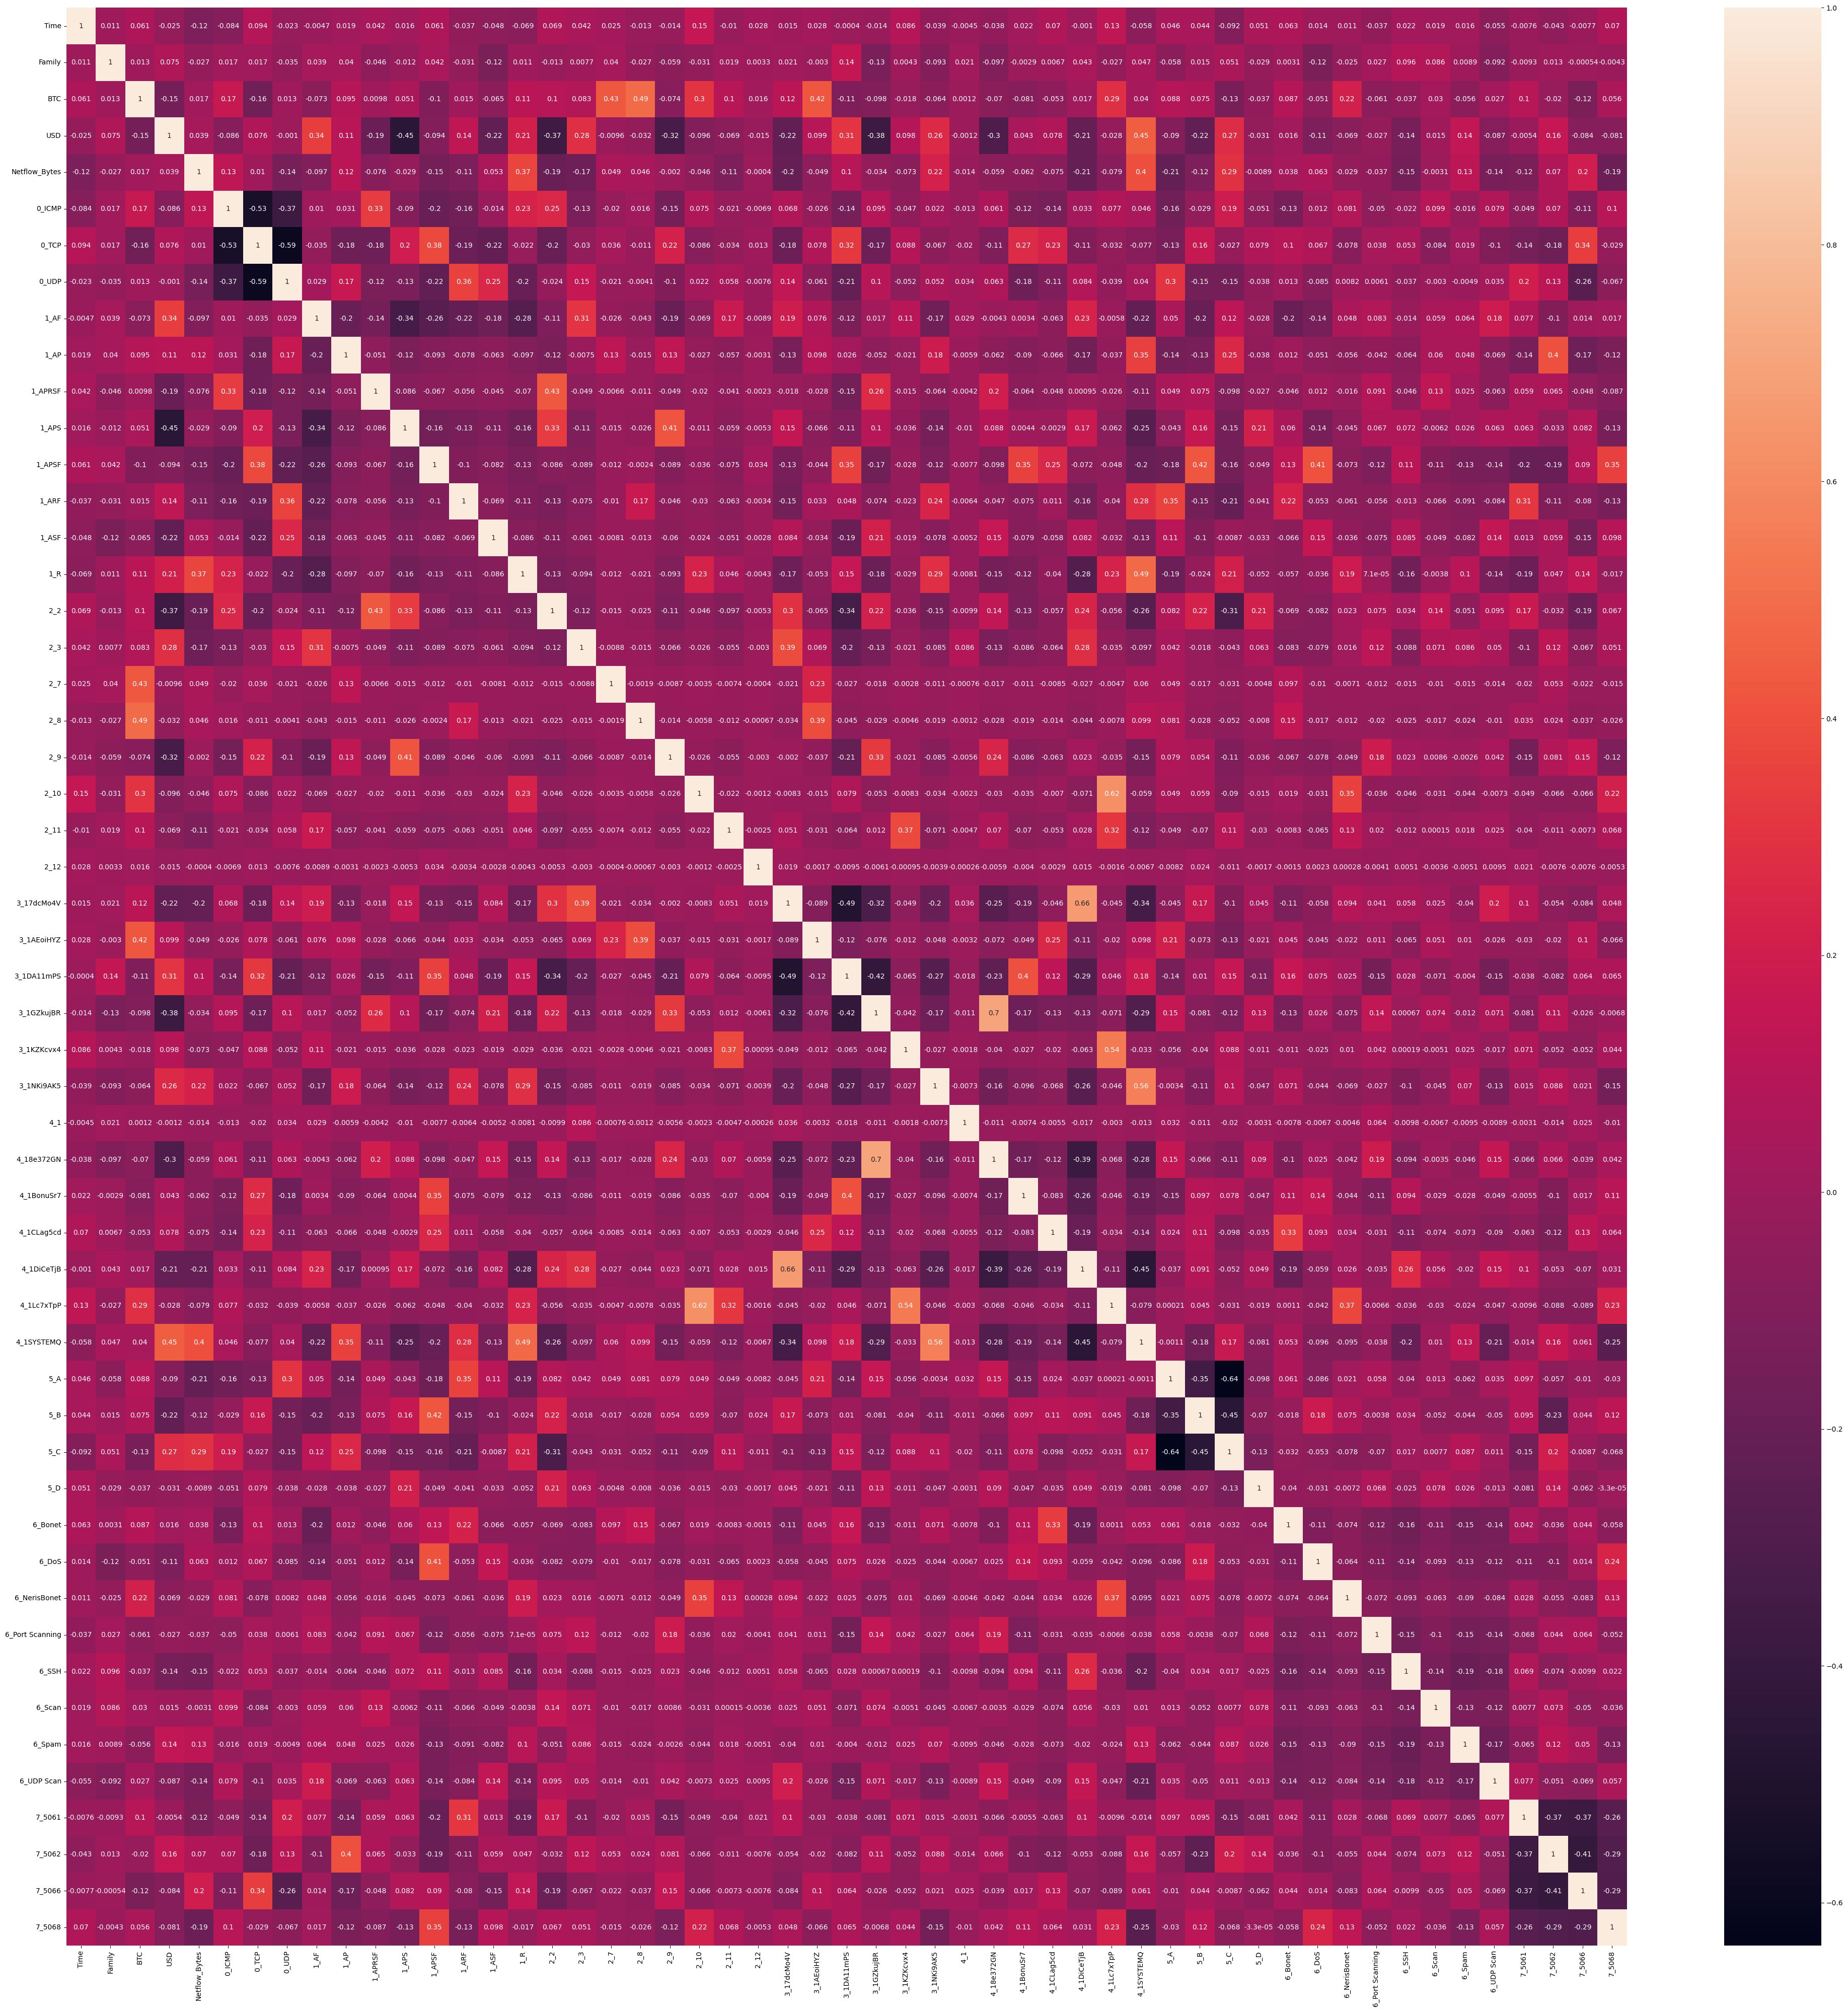

In [25]:
 # Observing Correlation Matrix
plt.figure(figsize = (50,50))
df4 = pd.concat([x_train_std,x_test_std])
sns.heatmap(df4.corr(),annot = True ,color = "b")
plt.show()

In [26]:
## Creating an Evaluation Matrix

Comparison_matrix = pd.DataFrame(np.zeros((10,4)),columns = ["Train_accuracy","Test_accuracy","Train_f1","Test_f1"])


def Evaluation(x_train,x_test,y_train,y_test,y_pred1,y_pred2,n):
  plt.figure(figsize=(15,6))
  cols =  x_train.loc[:,x_train.nunique()>15].columns.values
  fcc = np.random.choice(cols,3,replace = True)
  print("-"*30+">"+"Testing plots of diffferent features"+"<"+"-"*30)
  print()
  for i in range(len(fcc)):
    plt.subplot(2,3,i+1)
    plt.scatter(x_test[fcc[i]],y_test,label="Actual")
    plt.scatter(x_test[fcc[i]],y_pred2,label = "Predictions")
    plt.title(fcc[i])

  plt.show()

  print("METRICS OF MODEL".center(100))
  print(f"Training accuracy --------> {round(accuracy_score(y_train,y_pred1),4)}")
  print(f"Testing accuracy --------> {round(accuracy_score(y_test,y_pred2),4)}")
  print(f"Training f1_Score ---------> {round(f1_score(y_train,y_pred1,average='weighted'),4)}")
  print(f"Testing f1_Score ---------> {round(f1_score(y_test,y_pred2,average='weighted'),4)}")


  Comparison_matrix.loc[n,"Train_accuracy"] = round(accuracy_score(y_train,y_pred1),4)
  Comparison_matrix.loc[n,"Test_accuracy"] = round(accuracy_score(y_test,y_pred2),4)
  Comparison_matrix.loc[n,"Train_f1"] = round(f1_score(y_train,y_pred1,average="weighted"),4)
  Comparison_matrix.loc[n,"Test_f1"] = round(f1_score(y_test,y_pred2,average="weighted"),4)
  print("Errors".center(100))

  sns.displot(y_test-y_pred2)
  plt.title("ERROR Terms")
  plt.xlabel("Error Values")
  plt.show()
  # plt.subplot(1,2,2)
  # plt.scatter(y_train,preds1)
  # plt.plot([y_train.min(),y_train.max()],[y_train.min(),y_train.max()], 'r--')
  # plt.title('Test vs Prediction')
  # plt.xlabel('y_test')
  # plt.ylabel('y_pred')
  # plt.show()

# Predictive Modeling

## Starting with LinearSVC

In [27]:
# LinearSVC
lnrsvc = LinearSVC(C= 110,loss = "squared_hinge",verbose = 2) # Increase C if SVC underfitting otherwise decrease the value of C when overfitting
lnrsvc.fit(x_train_std,y_train)
y_pred1 = lnrsvc.predict(x_train_std)
y_pred2 = lnrsvc.predict(x_test_std)
Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,0)

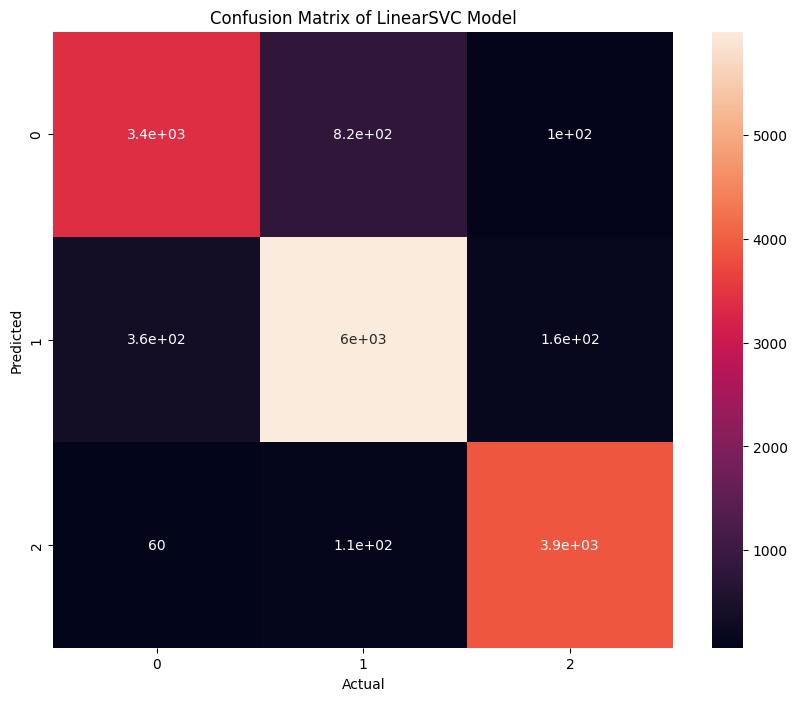

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of LinearSVC Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

------------------------------>Testing plots of diffferent features<------------------------------



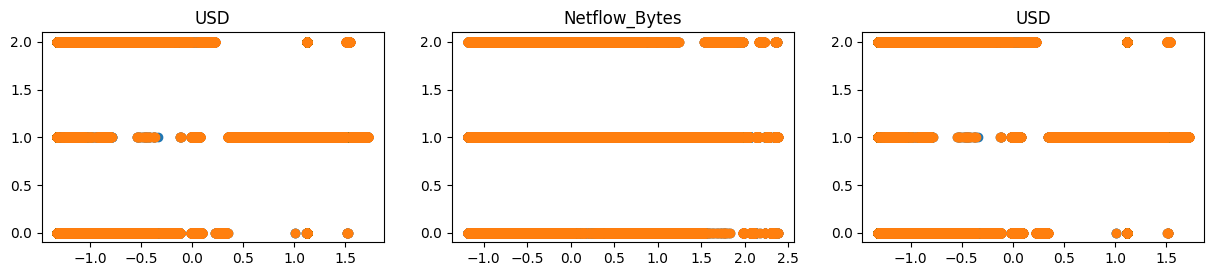

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9976
Testing accuracy --------> 0.9759
Training f1_Score ---------> 0.9976
Testing f1_Score ---------> 0.9759
                                               Errors                                               


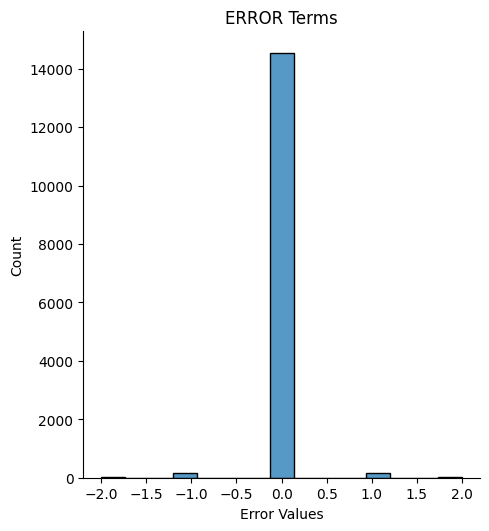

In [30]:
# KNearestNeighbors
knn = KNeighborsClassifier(n_neighbors=70,weights = "distance")
knn.fit(x_train_std,y_train)
y_pred1 = knn.predict(x_train_std)
y_pred2 = knn.predict(x_test_std)
Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,1)

> ### 🔑**Note**: keeping n_neighbors 0.01% for large data gives better result and setting up weight as distance when our data has signficant amount of outliers and mixed data increases performance of model else default (uniform) is sufficient.

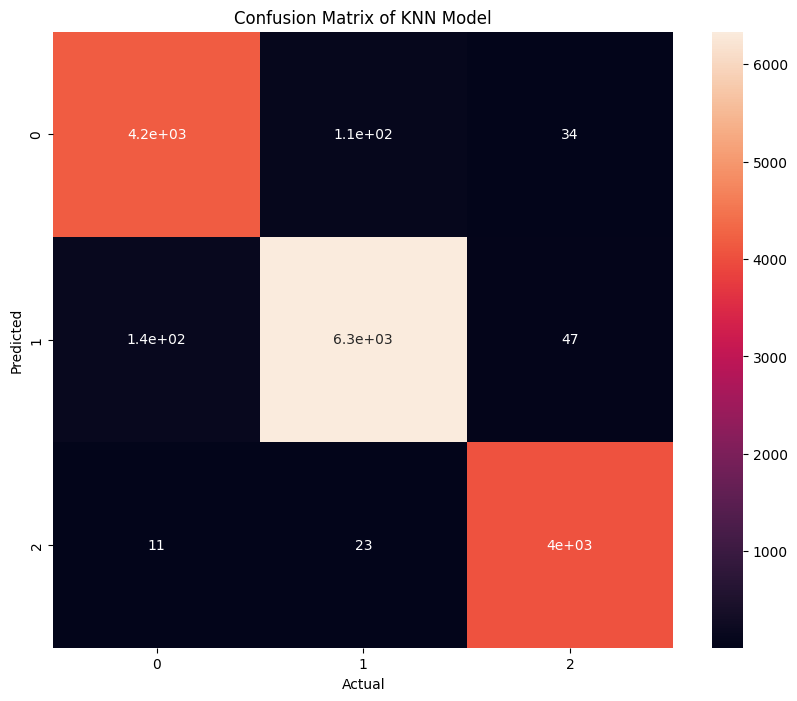

In [31]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of KNN Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

------------------------------>Testing plots of diffferent features<------------------------------



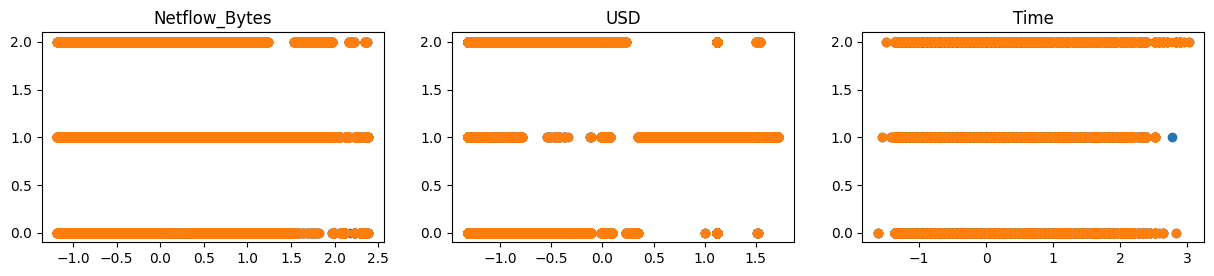

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9791
Testing accuracy --------> 0.9743
Training f1_Score ---------> 0.9791
Testing f1_Score ---------> 0.9743
                                               Errors                                               


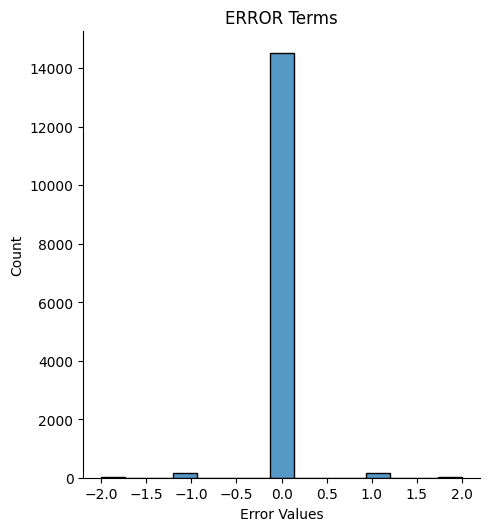

In [32]:
#kernel version of SVC

rbf = SVC(kernel = "rbf",C=10,class_weight="balanced")# class_weight,gamma , degree , C,probability,shrinking
rbf.fit(x_train_std,y_train)

y_pred1 = rbf.predict(x_train_std)
y_pred2 = rbf.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,2)

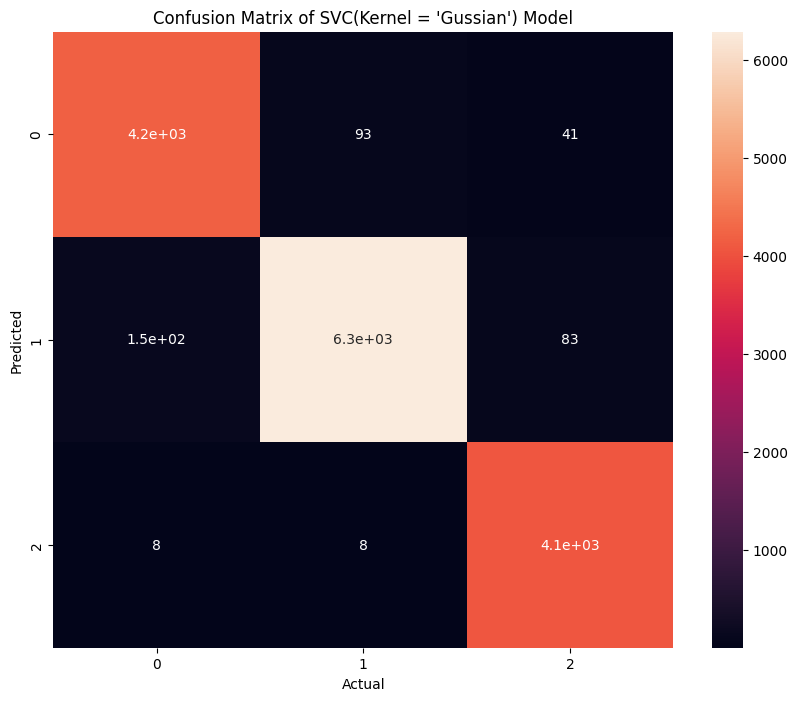

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of SVC(Kernel = 'Gussian') Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

------------------------------>Testing plots of diffferent features<------------------------------



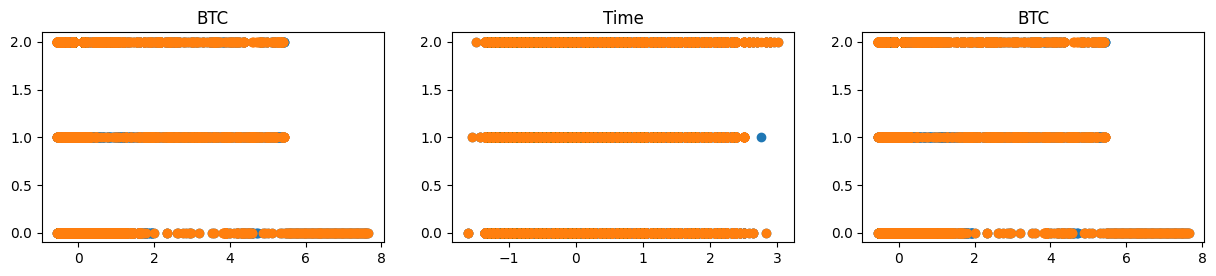

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9963
Testing accuracy --------> 0.9793
Training f1_Score ---------> 0.9963
Testing f1_Score ---------> 0.9793
                                               Errors                                               


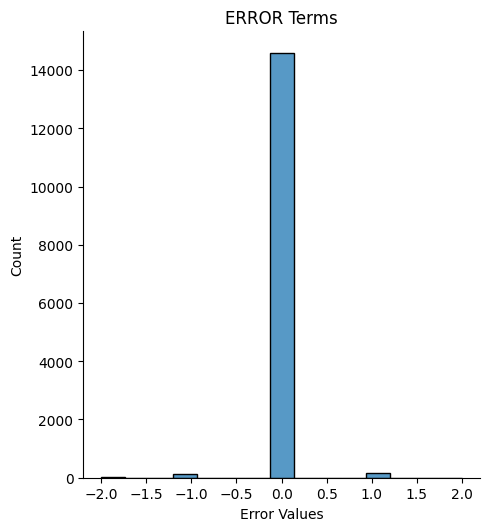

In [34]:
# Decisiontreeclassifier

dtc = DecisionTreeClassifier(criterion="gini",class_weight ="balanced",splitter="random",random_state=42,min_samples_split=9,max_features=90)
dtc.fit(x_train_std,y_train)

y_pred1 = dtc.predict(x_train_std)
y_pred2 = dtc.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,3)

> ### 🔑**Note:** In decisiontree models if the model overfits then it might be the result of learning data linearly so change splitter from 'best' to 'random' while selecting random choose random_state to produce data multiple times.
try to change the following hyperparameters below:
* `min_samples_split`
* `min_samples_leaf`
* `max_features`
* `max_leaf_nodes`
* `class_weight = balanced`

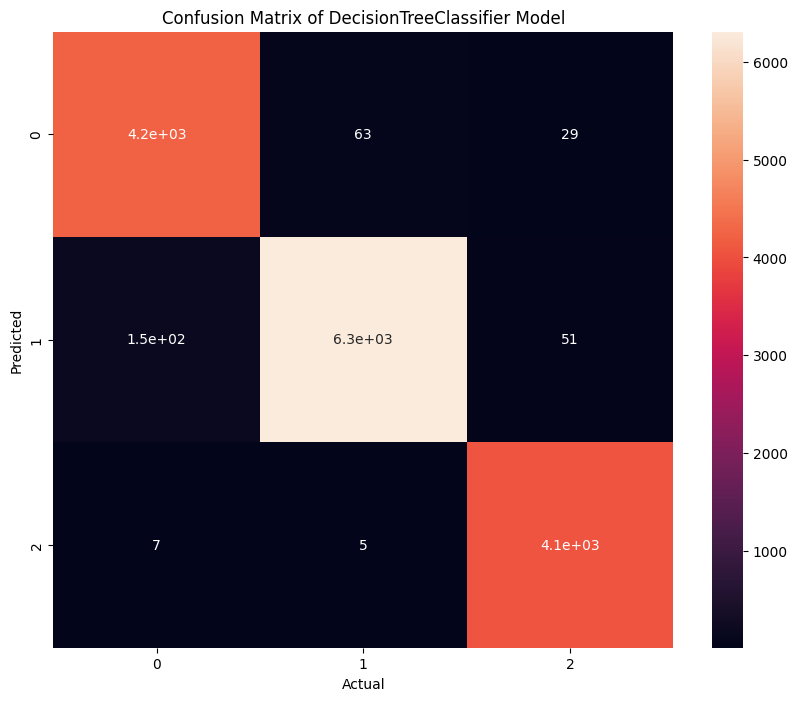

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of DecisionTreeClassifier Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

------------------------------>Testing plots of diffferent features<------------------------------



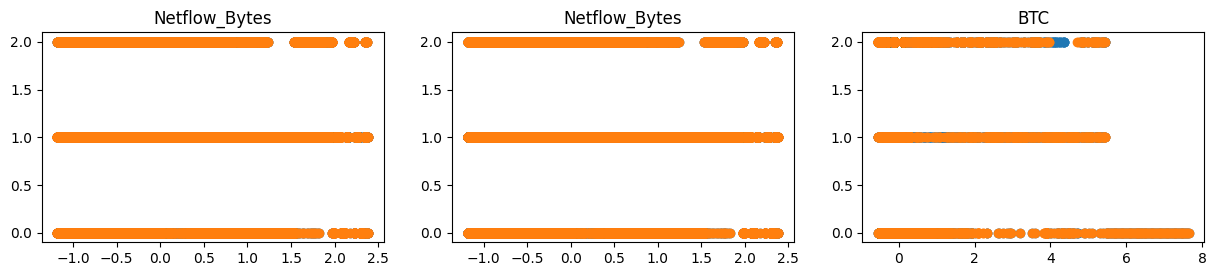

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9973
Testing accuracy --------> 0.9777
Training f1_Score ---------> 0.9973
Testing f1_Score ---------> 0.9777
                                               Errors                                               


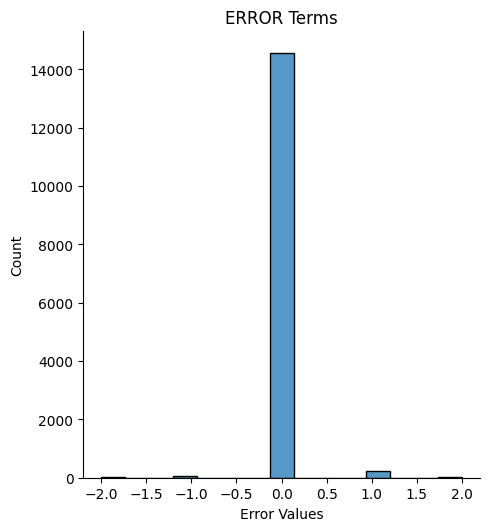

In [36]:
#ExtraTreeClassifier

etc = ExtraTreeClassifier(criterion="gini",random_state=123,min_samples_split=3,max_features=len(x_train_std))
etc.fit(x_train_std,y_train)

y_pred1 = etc.predict(x_train_std)
y_pred2 = etc.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,4)

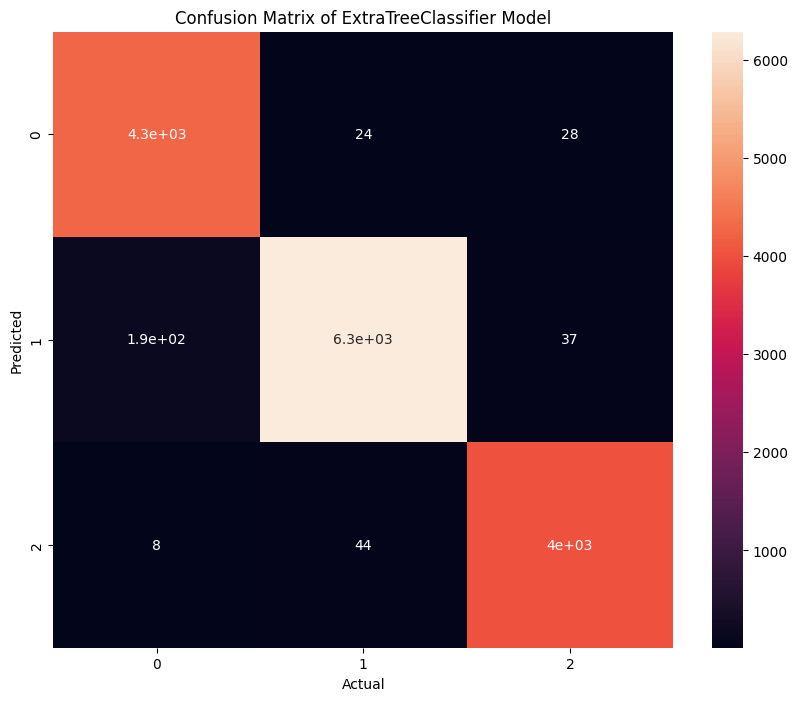

In [37]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of ExtraTreeClassifier Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [38]:
Comparison_matrix.to_csv("drive/MyDrive/Colab Notebooks/comparison_models_classification.csv",index =False)

In [39]:
pd.read_csv("/content/drive/MyDrive/Colab Notebooks/comparison_models_classification.csv")

,Train_accuracy,Test_accuracy,Train_f1,Test_f1
0,0.8878,0.8920,0.8869,0.8909
1,0.9976,0.9759,0.9976,0.9759
2,0.9791,0.9743,0.9791,0.9743
3,0.9963,0.9793,0.9963,0.9793
4,0.9973,0.9777,0.9973,0.9777
5,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC 0.909359275410936
KNeighborsClassifier 0.9759141227775914
ExtraTreeClassifier 0.9776585038577659
DecisionTreeClassifier 0.9792687017779269
[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingClassifier 0.9826232807782623
------------------------------>Testing plots of diffferent features<------------------------------



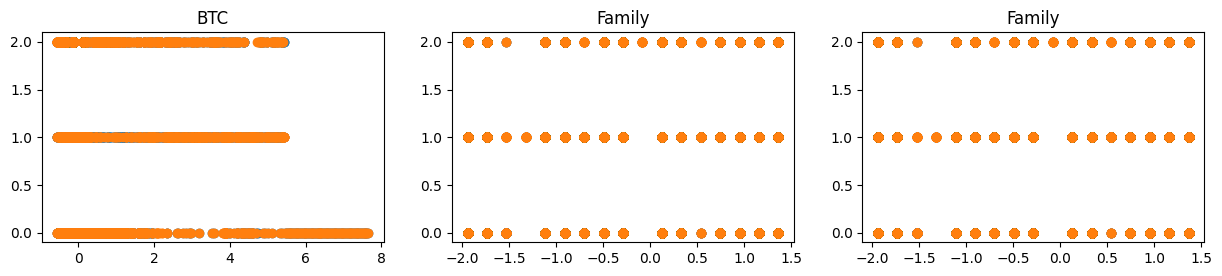

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9973
Testing accuracy --------> 0.9826
Training f1_Score ---------> 0.9973
Testing f1_Score ---------> 0.9826
                                               Errors                                               


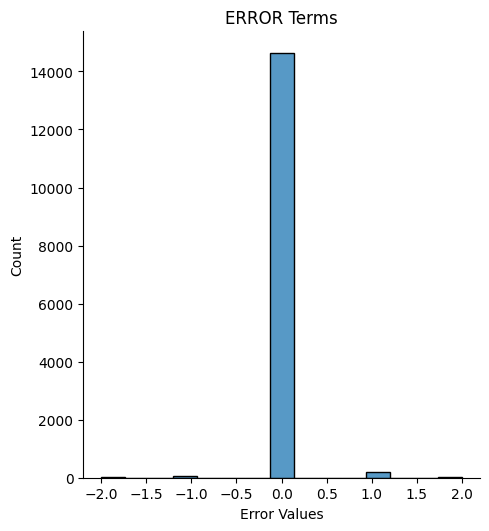

In [40]:
# Using votting_classifier 'hard' and 'soft' parameter to know which parameter generalizing more

from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[("lnrsvc",lnrsvc),("knn",knn),("dtc",dtc),("etc",etc)],voting="hard")

for clf in (lnrsvc,knn,etc,dtc,vc):
  clf.fit(x_train_std,y_train)
  print(clf.__class__.__name__,clf.score(x_test_std,y_test))

y_pred1 = vc.predict(x_train_std)
y_pred2 = vc.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,5)

In [41]:
# cheking soft voting
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[("rbf",SVC(kernel = "rbf",class_weight = "balanced",C=10,probability=True)),("knn",knn),("dtc",dtc),("etc",etc)],voting="soft")

for clf in (rbf,knn,etc,dtc,vc):
  clf.fit(x_train_std,y_train)
  print(clf.__class__.__name__,clf.score(x_test_std,y_test))


SVC 0.9743039248574304
KNeighborsClassifier 0.9759141227775914
ExtraTreeClassifier 0.9776585038577659
DecisionTreeClassifier 0.9792687017779269
VotingClassifier 0.9829587386782959


------------------------------>Testing plots of diffferent features<------------------------------



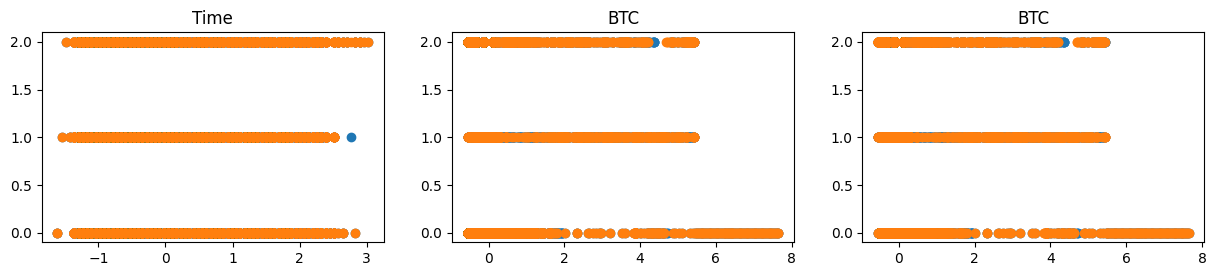

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9975
Testing accuracy --------> 0.983
Training f1_Score ---------> 0.9975
Testing f1_Score ---------> 0.983
                                               Errors                                               


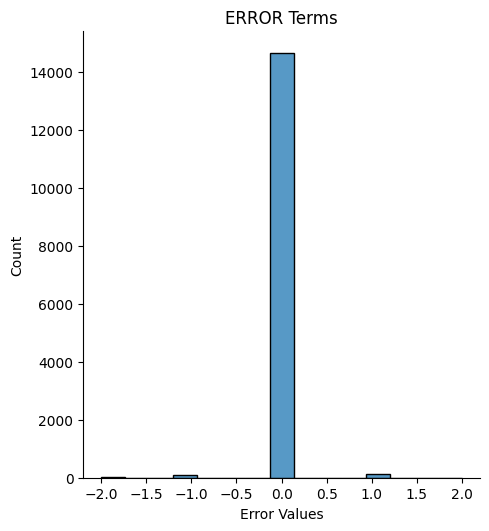

In [42]:
y_pred1 = vc.predict(x_train_std)
y_pred2 = vc.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,5)

### 🔑**Note:** In VotingClassifier setting up voting parameter as hard predicts the output by taking majority of votes of a class while soft selects the output by taking highest average probability of a class . while choosing `soft` parameter make sure all classifiers has *probability* as score evaluation metrics.

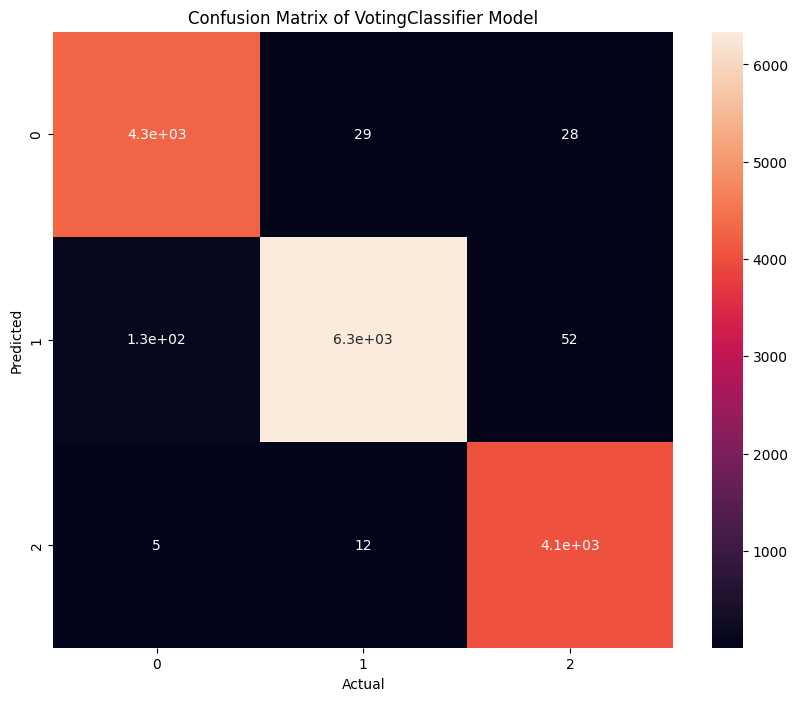

In [43]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of VotingClassifier Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [44]:
Comparison_matrix

,Train_accuracy,Test_accuracy,Train_f1,Test_f1
0,0.8878,0.8920,0.8869,0.8909
1,0.9976,0.9759,0.9976,0.9759
2,0.9791,0.9743,0.9791,0.9743
3,0.9963,0.9793,0.9963,0.9793
4,0.9973,0.9777,0.9973,0.9777
5,0.9975,0.9830,0.9975,0.9830
6,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000


------------------------------>Testing plots of diffferent features<------------------------------



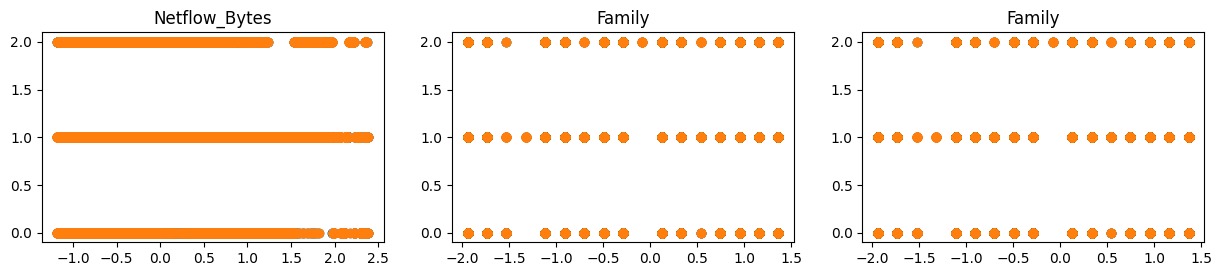

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9955
Testing accuracy --------> 0.9833
Training f1_Score ---------> 0.9955
Testing f1_Score ---------> 0.9833
                                               Errors                                               


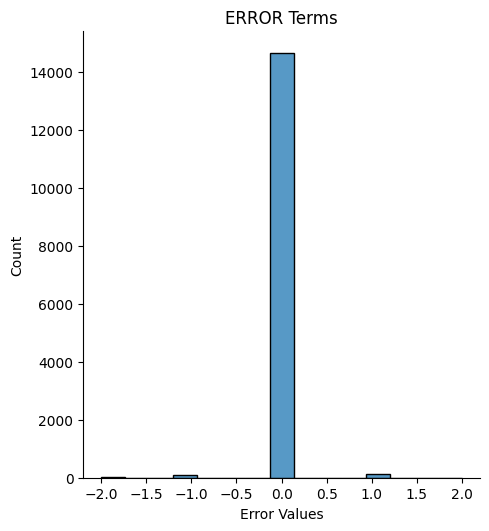

In [45]:
# Checking how BaggingClassifier works on our data

bag = BaggingClassifier(estimator = dtc,n_estimators = 100,oob_score = True,bootstrap_features=True,max_features=42)

bag.fit(x_train_std,y_train)
# bscore(x_test_std,y_test)

y_pred1 = bag.predict(x_train_std)
y_pred2 = bag.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,6)

### 🔑**Note:** First let's know about what is BaggingClassifier ,it generally doesn't have any specific algo , it impliments the algorithm of the `estimator`  we provided after making small changes in data batches for training like random selection and random_features_selection by turning on `bootstrap_features`.

In [46]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4316
           1       0.99      0.98      0.98      6516
           2       0.98      0.99      0.99      4073

    accuracy                           0.98     14905
   macro avg       0.98      0.98      0.98     14905
weighted avg       0.98      0.98      0.98     14905



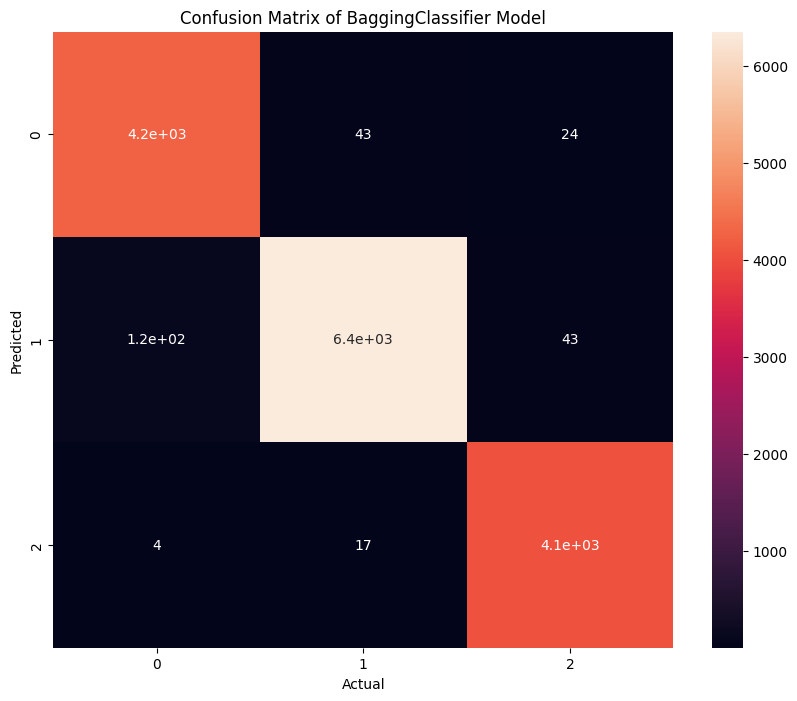

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of BaggingClassifier Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

## AdaptiveBoosting (AdaBoost) Technique

> ### In this algorithm , new_predictors(estimators) correct its predecessor errors by paying more attention to the training instances that are `underfitted` by predecessor.
* sklearn uses SAMME.R(Default) converges faster and SAMME (Stagewise Adaptive Modelling and Multiclass Exponential loss function) .


------------------------------>Testing plots of diffferent features<------------------------------



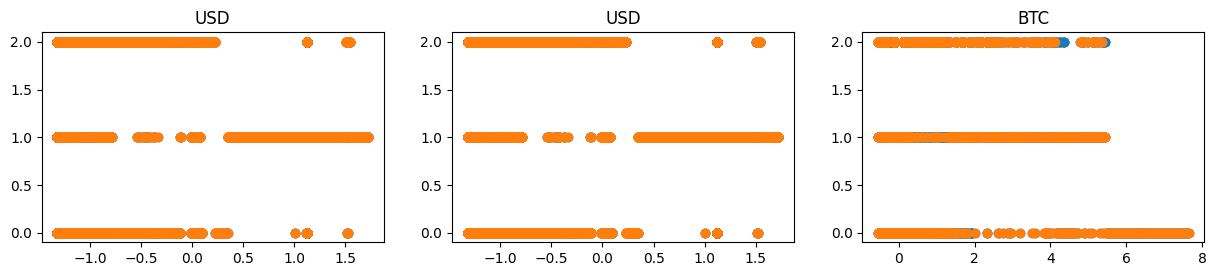

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9976
Testing accuracy --------> 0.982
Training f1_Score ---------> 0.9976
Testing f1_Score ---------> 0.982
                                               Errors                                               


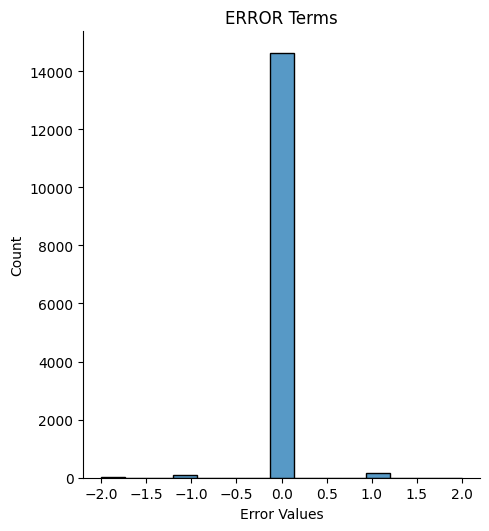

In [48]:
# using Adaptive learning technique

ada_clf = AdaBoostClassifier(estimator=etc,n_estimators = 100,learning_rate = 0.4,algorithm="SAMME.R" ) # here i select Extratrees , u can select any algorithm
ada_clf.fit(x_train_std,y_train)
# ada_clf.score(x_test_std,y_test)

y_pred1 = ada_clf.predict(x_train_std)
y_pred2 = ada_clf.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,7)

### 🔑**Note:** If AdaBoostingClassifier or anyother is not regularizing for its best then , increasing the `n_estimators` and decreasing the `learning_rate` enhances regularization. this type of regularization is called *Shrinkage*.



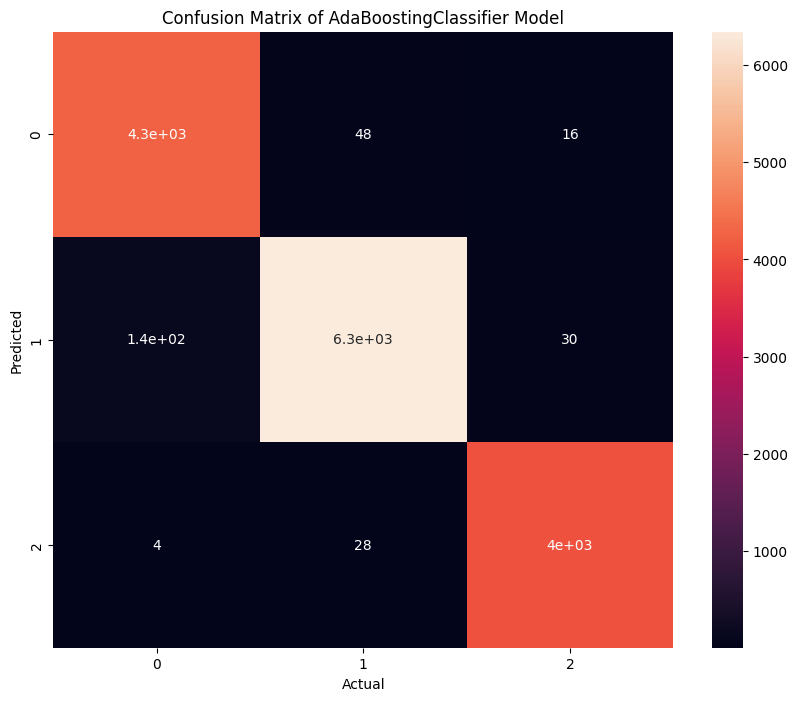

In [49]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of AdaBoostingClassifier Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

## GradientBoostingClassifier
> ### In AdaBoost algorith the new_predictors learn by increasing the weights of the samples wrongly predicted by previous predictor(estimator). while in this algorithm the new_predictor learns the error value of previous sample e.g. if y = 6 , let's assume predictor_1 estimates it as 4 then y_error = 2 is the new label to x_train of that sample for new predictor atlast the estimation of a label is done by adding sum(y_predictor_1 +y_predictor_2....) .

In [50]:
# Using GradientBoosting Technique

gbc = GradientBoostingClassifier(learning_rate = 0.05,n_estimators=250)
gbc.fit(x_train_std,y_train)

gbc.score(x_test_std,y_test)

0.9500167728950016

------------------------------>Testing plots of diffferent features<------------------------------



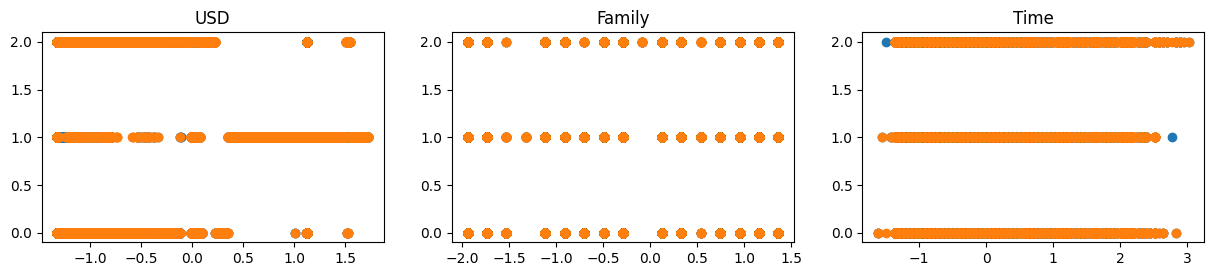

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9793
Testing accuracy --------> 0.9563
Training f1_Score ---------> 0.9792
Testing f1_Score ---------> 0.9564
                                               Errors                                               


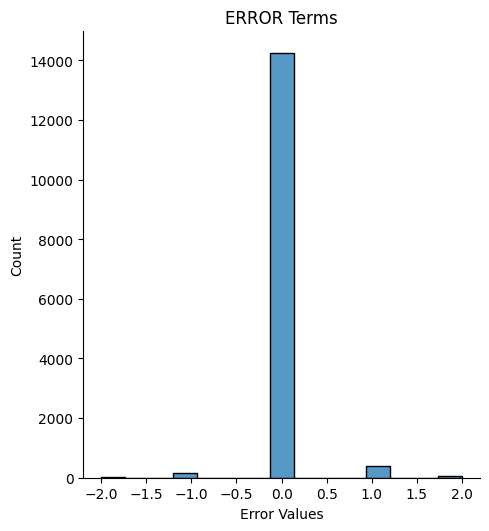

In [51]:
# final model

gbc = GradientBoostingClassifier(n_estimators = 534, learning_rate = 0.03,max_features = 20, min_samples_leaf = 3 , min_samples_split=20)
gbc.fit(x_train_std,y_train)

y_pred1 = gbc.predict(x_train_std)
y_pred2 = gbc.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,8)

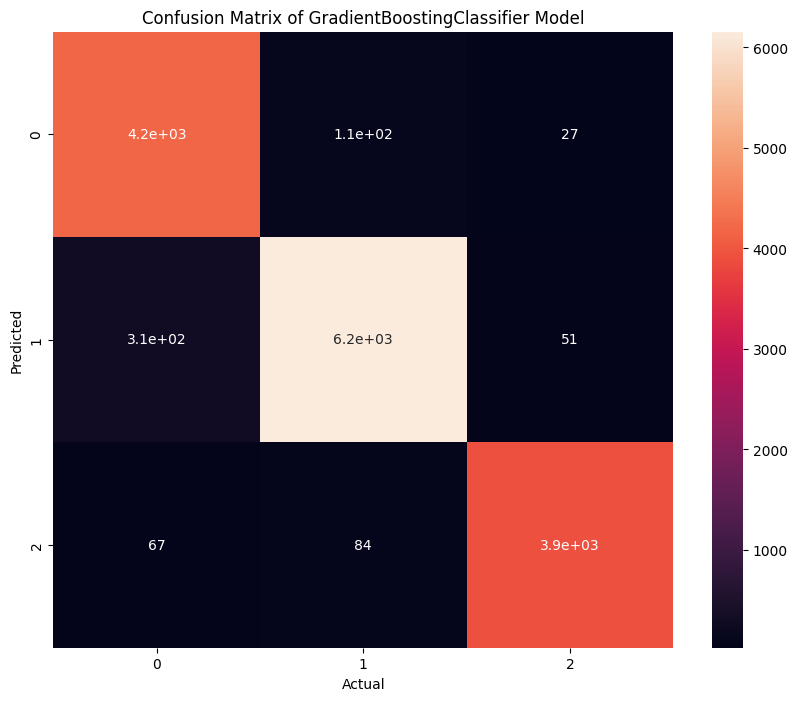

In [52]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of GradientBoostingClassifier Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

------------------------------>Testing plots of diffferent features<------------------------------



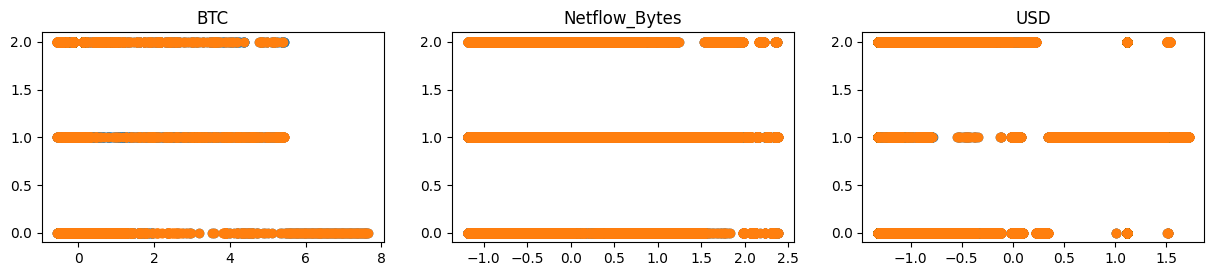

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.9957
Testing accuracy --------> 0.9752
Training f1_Score ---------> 0.9957
Testing f1_Score ---------> 0.9753
                                               Errors                                               


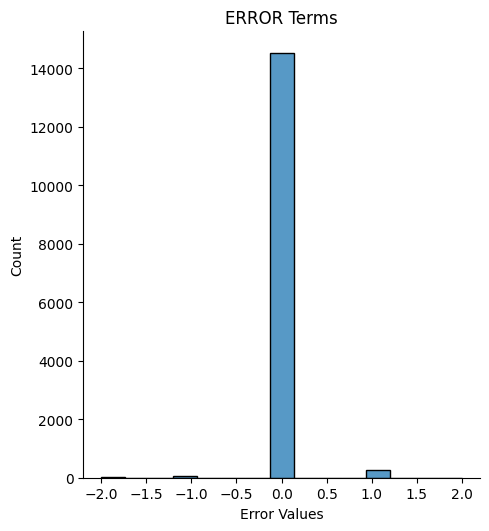

In [53]:
# finalising the model with best params

rfc = RandomForestClassifier(n_estimators = 600,max_features = "sqrt",max_depth = 18,min_samples_split = 3,criterion="entropy") # Taking the params after tweaking like hit and trail method
rfc.fit(x_train_std,y_train)

y_pred1 = rfc.predict(x_train_std)
y_pred2 = rfc.predict(x_test_std)

Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,9)

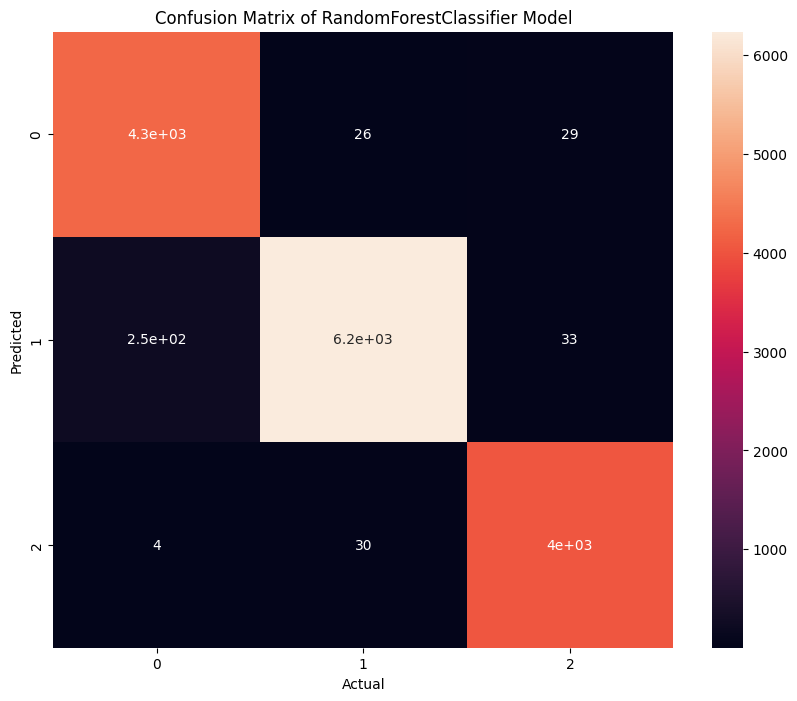

In [54]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True)
plt.title("Confusion Matrix of RandomForestClassifier Model")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [55]:
Comparison_matrix.to_csv("drive/MyDrive/Colab Notebooks/comparison_models_classification.csv",index =False)

In [56]:
# Classificatoin Models Results Evaluation

EMC = Comparison_matrix.copy()
EMC.index = ["LinearSVC","KNN","SVC(kernel='rbf')","DecisionTreeClassifier","ExtraTreeClassifier","VotingClassifier","BaggingClassifier","AdaBoostClassifier","GradientBoosting","RandomForestClassifier"]
EMC

,Train_accuracy,Test_accuracy,Train_f1,Test_f1
LinearSVC,0.8878,0.8920,0.8869,0.8909
KNN,0.9976,0.9759,0.9976,0.9759
SVC(kernel='rbf'),0.9791,0.9743,0.9791,0.9743
DecisionTreeClassifier,0.9963,0.9793,0.9963,0.9793
ExtraTreeClassifier,0.9973,0.9777,0.9973,0.9777
VotingClassifier,0.9975,0.9830,0.9975,0.9830
BaggingClassifier,0.9955,0.9833,0.9955,0.9833
AdaBoostClassifier,0.9976,0.9820,0.9976,0.9820
GradientBoosting,0.9793,0.9563,0.9792,0.9564
RandomForestClassifier,0.9957,0.9752,0.9957,0.9753


In [57]:
EMC.to_csv("drive/MyDrive/Colab Notebooks/classification.csv")

In [58]:
pd.read_csv("drive/MyDrive/Colab Notebooks/classification.csv")

,Unnamed: 0,Train_accuracy,Test_accuracy,Train_f1,Test_f1
0,LinearSVC,0.8878,0.8920,0.8869,0.8909
1,KNN,0.9976,0.9759,0.9976,0.9759
2,SVC(kernel='rbf'),0.9791,0.9743,0.9791,0.9743
3,DecisionTreeClassifier,0.9963,0.9793,0.9963,0.9793
4,ExtraTreeClassifier,0.9973,0.9777,0.9973,0.9777
5,VotingClassifier,0.9975,0.9830,0.9975,0.9830
6,BaggingClassifier,0.9955,0.9833,0.9955,0.9833
7,AdaBoostClassifier,0.9976,0.9820,0.9976,0.9820
8,GradientBoosting,0.9793,0.9563,0.9792,0.9564
9,RandomForestClassifier,0.9957,0.9752,0.9957,0.9753


# Predictive Modeling after Dimensionality Reduction

# Using PCA for Dimensionality redution

In [92]:
# PCA

pca = PCA()
pca.fit(x_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)
n_components = d

In [97]:
pca = PCA(n_components= n_components)
x_red_train = pca.fit_transform(x_train_std)
x_red_test = pca.fit_transform(x_test_std)
rfc.fit(x_red_train,y_train)
rfc.score(x_red_test,y_test)

0.811539751761154

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


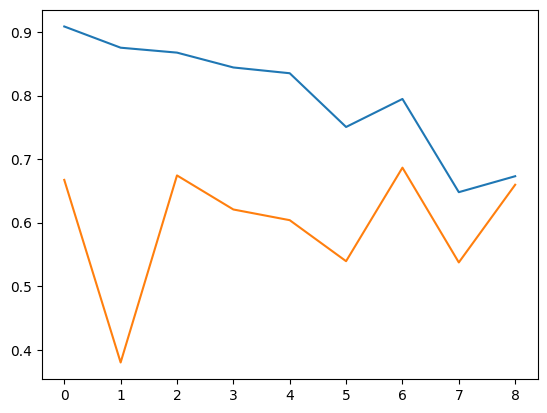

In [59]:
# LinearSVC
trr=[]
tss=[]
m=x_train.shape[1]-2
for i in range(0,m,6):
  pca=PCA(n_components = m-i)
  x_red_train = pca.fit_transform(x_train_std)
  x_red_test = pca.fit_transform(x_test_std)

  lnrsvc.fit(x_red_train,y_train)
  y_pred1 = lnrsvc.predict(x_red_train)
  y_pred2 = lnrsvc.predict(x_red_test)

  trr.append(accuracy_score(y_train,y_pred1))
  tss.append(accuracy_score(y_test,y_pred2))
plt.plot(trr,label = "Training")
plt.plot(tss,label = "Testing")

In [ ]:
# # Since from above there is no use of dimension reduction from dataset for linearsvc we will use normal data

# lnrsvc.fit(x_train_std,y_train)
# y_pred1 = lnrsvc.predict(x_train_std)
# y_pred2 = lnrsvc.predict(x_test_std)



------------------------------>Testing plots of diffferent features<------------------------------



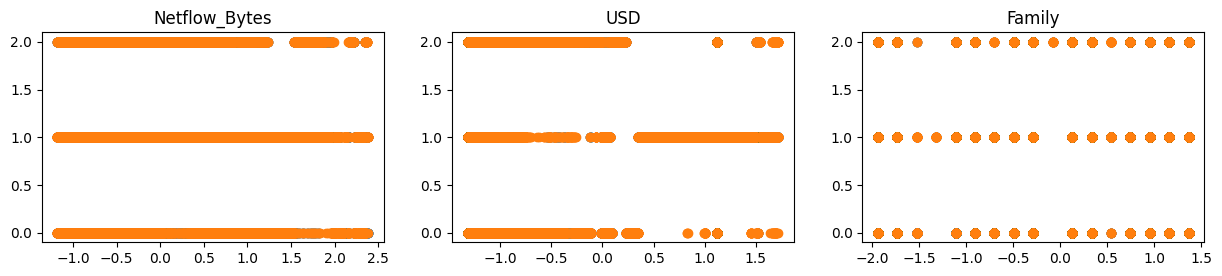

                                          METRICS OF MODEL                                          
Training accuracy --------> 0.8979
Testing accuracy --------> 0.9009
Training f1_Score ---------> 0.8977
Testing f1_Score ---------> 0.9005
                                               Errors                                               


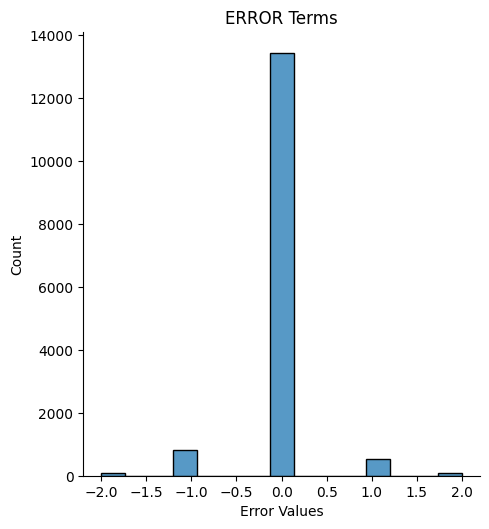

In [62]:
Evaluation(x_train_std,x_test_std,y_train,y_test,y_pred1,y_pred2,0)

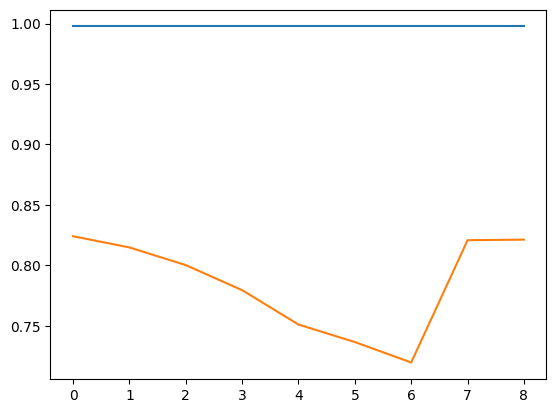

In [63]:
# KNN
trr=[]
tss=[]
m=x_train.shape[1]-2
for i in range(0,m,6):
  pca=PCA(n_components = m-i)
  x_red_train = pca.fit_transform(x_train_std)
  x_red_test = pca.fit_transform(x_test_std)

  knn.fit(x_red_train,y_train)
  y_pred1 = knn.predict(x_red_train)
  y_pred2 = knn.predict(x_red_test)

  trr.append(accuracy_score(y_train,y_pred1))
  tss.append(accuracy_score(y_test,y_pred2))
plt.plot(trr,label = "Training")
plt.plot(tss,label = "Testing")

In [ ]:
# SVC (kernel = 'rbf')

trr=[]
tss=[]
m=x_train.shape[1]-2
for i in range(m):
  pca=PCA(n_components = m-i)
  x_red_train = pca.fit_transform(x_train_std)
  x_red_test = pca.fit_transform(x_test_std)

  rbf.fit(x_red_train,y_train)
  y_pred1 = rbf.predict(x_red_train)
  y_pred2 = rbf.predict(x_red_test)

  trr.append(accuracy_score(y_train,y_pred1))
  tss.append(accuracy_score(y_test,y_pred2))
plt.plot(trr,label = "Training")
plt.plot(tss,label = "Testing")

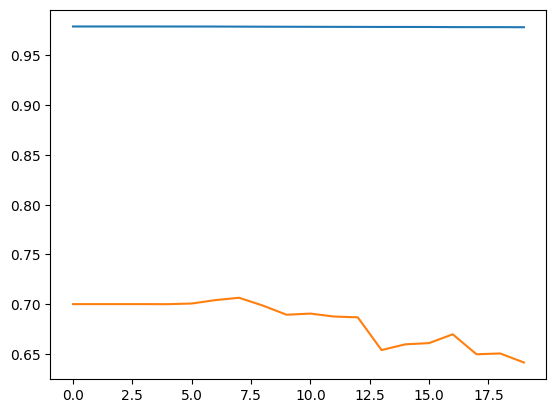

In [65]:
plt.plot(trr,label = "Training")
plt.plot(tss,label = "Testing")

#Note:  there is no improvement in knn also , instead we have seen large downfall

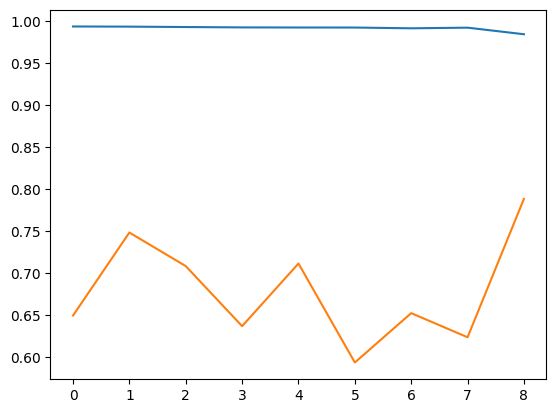

In [66]:
#Decision TreeClassifier

trr=[]
tss=[]
m=x_train.shape[1]-2
for i in range(0,m,6):
  pca=PCA(n_components = m-i)
  x_red_train = pca.fit_transform(x_train_std)
  x_red_test = pca.fit_transform(x_test_std)

  dtc.fit(x_red_train,y_train)
  y_pred1 = dtc.predict(x_red_train)
  y_pred2 = dtc.predict(x_red_test)

  trr.append(accuracy_score(y_train,y_pred1))
  tss.append(accuracy_score(y_test,y_pred2))
plt.plot(trr,label = "Training")
plt.plot(tss,label = "Testing")

In [68]:
pca = PCA(n_components = m-48)
x_train_red = pca.fit_transform(x_train_std)
x_test_red = pca.fit_transform(x_test_std)

dtc.fit(x_train_red,y_train)
dtc.score(x_test_red,y_test)

0.7934921167393492

# Using KernelPCA

In [27]:
dtc = DecisionTreeClassifier(criterion="gini",class_weight ="balanced",splitter="random",random_state=42,min_samples_split=9,max_features=90)

In [ ]:
from sklearn.decomposition import KernelPCA
clf = Pipeline([("kpca",KernelPCA(n_components = 50)),("dtc",dtc)])
param_grid = [{"kpca__gamma":np.linspace(0.03,0.05,10),"kpca__kernel":["rbf","sigmoid"]}]

grid = GridSearchCV(clf,param_grid)
grid.fit(x_train_std[:10000],y_train[:10000])
# y_pred = grid.predict(x_train_std)
# accuracy_score(y_train,y_pred)

In [30]:
kpca = KernelPCA(n_components = 10)
x_train_red = kpca.fit_transform(x_train_std[:10000])
x_test_red = kpca.fit_transform(x_test_std)

dtc.fit(x_train_red[:10000],y_train[:10000])
y_pred = dtc.predict(x_train_red[:10000])
accuracy_score(y_train[:10000],y_pred)


0.9772

In [31]:
y_pred2 = dtc.predict(x_test_red)
accuracy_score(y_test,y_pred2)

0.5021133847702114

># 🔑Note: Clearly here there is no use of Dimensionality reduction in this Dataset , its making our results more worse.